In [39]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage.filters as skfil
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import img_as_ubyte
from functions import reorder_file_paths, extract_filename_number
from scipy import ndimage
from skimage.color import label2rgb
from skimage import measure

Remove green pixels from the image and mask them out with black

In [2]:
img_number = 25

# Load in RGBVI image that contains rocks
rgbvi_img = cv2.imread(f'results/cropped_rgbvi_gray/image_{img_number}.jpg', 0)

# Also load in the actual image
img = cv2.imread(f'test_photos_cropped/image_{img_number}.jpg')

# plt.hist(rgbvi_img.flatten(), bins = 100)

# Threshold it to only include plants
ret, thresh = cv2.threshold(rgbvi_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Define a kernel for morphological operations
kernel = np.ones((3,3), np.uint8)

# Dilate the image
img_dilated = cv2.dilate(thresh, kernel, iterations = 2)

# Then erode it
img_dilated_eroded = cv2.erode(img_dilated, kernel, iterations = 1)

# Invert the image so it'll capture everything but the plants
mask = cv2.bitwise_not(img_dilated_eroded)

img_masked = cv2.bitwise_and(img, img, mask = mask)


# plt.imshow(img_masked)
cv2.imshow('masked', img_masked)

cv2.waitKey(0)
cv2.destroyAllWindows()

Try it on all the photos

In [3]:
# Get list of files in folders that contain the og cropped photos and their rgbvi counterparts
files_og = reorder_file_paths('test_photos_cropped\\*')
files_rgbvi = reorder_file_paths('results\\cropped_rgbvi\\*')

# Define a kernel for morphological operations
kernel = np.ones((3,3), np.uint8)

In [36]:
for i in range(len(files_og)):
    img_og = cv2.imread(files_og[i]) # Load in original file
    img_rgbvi = cv2.imread(files_rgbvi[i], 0) # Load in RGBVI image

    file_number = extract_filename_number(files_og[i])

    # Threshold RGBVI image to only include plants
    _, img_thresholded = cv2.threshold(img_rgbvi, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # thresh = skfil.threshold_otsu(img_rgbvi) 
    # img_thresholded = img_rgbvi <= thresh # dark pixels true, light pixels false
    # img_thresholded = img_as_ubyte(img_thresholded) # Convert back to ubyte

    # Dilate the image
    img_dilated = cv2.dilate(img_thresholded, kernel, iterations = 2)

    # Then erode it
    img_dilated_eroded = cv2.erode(img_dilated, kernel, iterations = 1)

    # Invert the image so it'll capture everything but the plants
    mask = cv2.bitwise_not(img_dilated_eroded)


    # Ensure mask is the same size and type as img_og
    if mask.shape != img_og.shape[:2]:
        mask = cv2.resize(mask, (img_og.shape[1], img_og.shape[0]))
    if mask.dtype != img_og.dtype:
        mask = mask.astype(img_og.dtype)

    img_masked = cv2.bitwise_and(img_og, img_og, mask = mask)

    # plt.imshow(img_masked)
    cv2.imwrite(f'results/erasing_green/image_{file_number}.jpg', img_masked)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

    

Entropy filter didn't really accomplish anything. Do grain size analysis on what i have

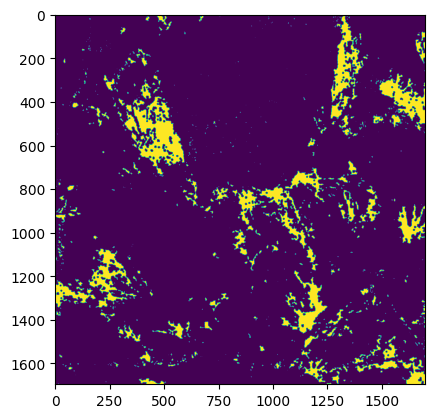

In [93]:
# Define kernel
kernel = np.ones((5,5), np.uint8)

img = cv2.imread('results/erasing_green/image_27.jpg', 0)

img_blurred = cv2.GaussianBlur(img, (5, 5), 0)

entropy_img = entropy(img_blurred, disk(3))

# fig, ax = skfil.try_all_threshold(entropy_img, figsize=(10,8), verbose=False)

entropy_thresh = skfil.threshold_otsu(entropy_img)
binary = entropy_img <= entropy_thresh

# _, img_thresholded = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# # Try edge detection
# edges = cv2.Canny(img_blurred, 150, 200)

# # Threshold
# _, binary = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# img_thresholded = cv2.erode(binary, kernel, iterations = 3)
# img_thresholded = cv2.dilate(binary, kernel, iterations = 1)

plt.imshow(binary)

In [37]:
# plt.hist(img.flat, bins = 100)

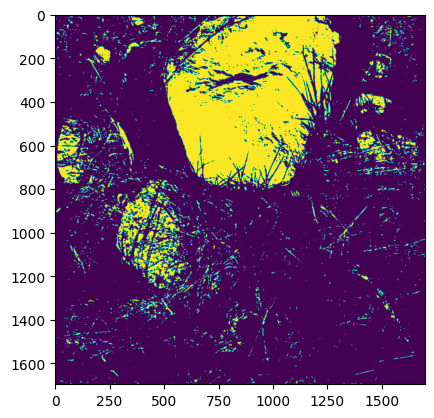

In [4]:
img = cv2.imread('results/erasing_green/image_27.jpg', 0)

img_blurred = cv2.GaussianBlur(img, (9, 9), 0)

white = img_blurred > 165

plt.imshow(white)

Try some morphological operations here

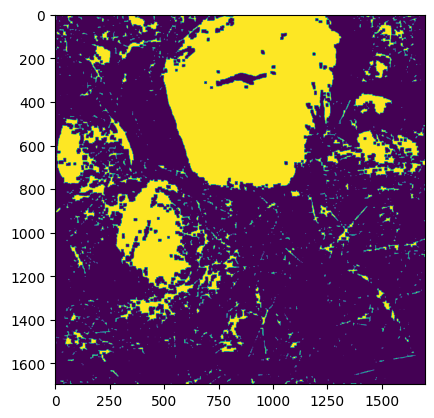

In [35]:
morphed_img = img_as_ubyte(white)

morphed_img = cv2.dilate(morphed_img, kernel, iterations = 5)
morphed_img = cv2.erode(morphed_img, kernel, iterations = 5)


plt.imshow(morphed_img)

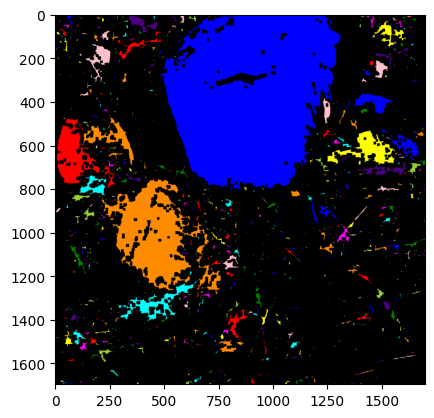

In [36]:
# Define structure - connection between shapes
s = [[1,1,1], [1,1,1], [1,1,1]] # 8 connectivity - diagonal pixels are included as part of the structure.
# structure specifies how to consider a pixel as part of an object

# Label the mask (give it the pretty gradient thing)
label_mask, num_labels = ndimage.label(morphed_img, structure=s)

img_color = label2rgb(label_mask, bg_label = 0) # Assign random colors

plt.imshow(img_color)

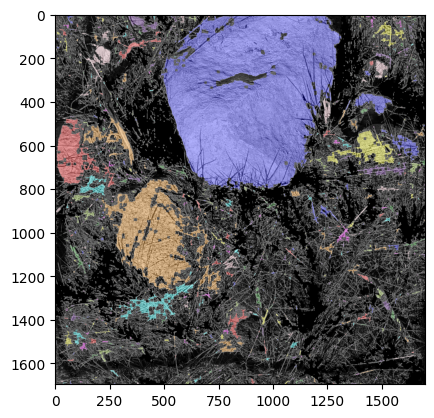

In [38]:
# Overlays labelled image on top of og image.
image_label_overlay = label2rgb(label_mask, image=img)

plt.imshow(image_label_overlay)

In [40]:
# Get information about clusters
clusters = measure.regionprops(label_mask, intensity_image=img)


# Put output into a csv file
cols = ['Area',
             'equivalent_diameter',
             'orientation',
             'MajorAxisLength',
             'MinorAxisLength',
             'Perimeter',
             'MinIntensity',
             'MeanIntensity',
             'MaxIntensity',
             ]

# Write it out to a csv file
output_file = open('image_measurements.csv', 'w') # write mode
output_file.write(',' + ','.join(cols) + '\n') # Add header to csv

120